**Variational Auto Encoder trained on MNIST using Tensorflow.**

*by Sodikov Makhmood. MIPT DIHT 2019.*

In [2]:
!pip install imageio

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import numpy as np
import pandas as pd
from IPython import display

I am going to implement a basic VAE (Variational Autoencoder) model on Tensorflow, trained on MNIST dataset. 

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Now we will normalize and reshape our images.
Each cell contains one number, which describes darkness of current pixel, so every cell is in [0,255]. Hence, we will normalize every pixel to 255.

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

0


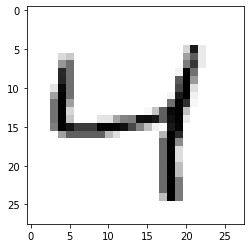

4


In [6]:
def show_num(arr):
    img = arr.reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()
print(0)


# testing 
show_num(tf.keras.datasets.mnist.load_data()[0][0][2])
print(tf.keras.datasets.mnist.load_data()[0][1][2])

Let's divide our dataset to train and test sets. 

So, we will train on 60k examples vs 10k we use to test.

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

Let  and  denote the observation $x$ and latent variable $z$ respectively in the following descriptions. We use Keras.Sequential, because the architecture of our NN is pretty simple (on MNIST).

Let's shuffle our data and divide to batches, each from 100 tensors.


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

Our neural net will be divided to two independent layers -- decoder and encoder.

Encoder will have the following architecture: 

* Input layer, that takes one image (matrix) of 28x28 dimension (or 28x28x1 tensor -- classical dim for picture from MNIST)

* Two convolutional layers -- каждый из которых имеет фильтры размеров 32 и 64 (перевести)

* Flatten layers and fully connected dense layer for summarizing all values from others to give the inference

------

Decoder layer consist of:

* Input layer (latent_dim)

* Dense layer of shape 7x7x32 with ReLU activation function

* Reshape layer which connected with 2 stacked DEconv layers that will resize to the original image size

-------

We also have encoder and decoder function. First one splits our inference vector to two others: mean and logvar. 

Then we will sample new random vector from Norm(mean, logvar) and decode it to get new image. 

In [0]:
class VAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim

    # Decoder Net
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
          # Getting 2 vectors, each of latent_dim size 
      ]
    )

    # Encoder Net
    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )
 
  @tf.function
  def sample(self, eps=None):
    # getting samples from norm () and decoding it
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    # tf.split() splits a tensor into sub tensors.
    # so we will split our vector of 2*latent_dim size to mean (expectation) and
    # logvar (sigma) of norm(mean, sigm)

    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    # Reparametrization trick to improve 
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  # decoder returns logits with sigmoid cross entropy (if parameter called)
  # or without it  
  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

Here we set optimizer (you can also try with other optimizers to feel the difference between them).

`compute_loss` -- computes Reconstruction Loss between our original and decoded image.


In [0]:
# you could also try:
# optimizer = tf.keras.optimizers.Adam(5e-4)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01) 
# or:
# optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True(???))

optimizer = tf.keras.optimizers.Adam(1e-4)

# Log norm pdf (getting sample from norm dist)
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# Reconstruction loss
@tf.function
def compute_loss(model, x):
# get mean and logvar
  mean, logvar = model.encode(x)  # use model in order not to re
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Countiong grads with given optimizer
@tf.function
def compute_apply_gradients(model, x, optimizer_):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer_.apply_gradients(zip(gradients, model.trainable_variables))

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

We will not compute the KL term, but use the MC approach.

In [0]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

The following code sample will create a sample from decoder with random sample from distribution.


In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

#   for i in range(predictions.shape[0]):
#       plt.subplot(4, 12, i+1)
#       plt.imshow(predictions[i], cmap='gray')
#       plt.axis('off')
#       plt.show() 

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

For each epoch we will count gradients with optimizer and mean for reconst loss, and get the 

Epoch: 100, Test set ELBO: -78.14427947998047, time elapse for current epoch 87.87407112121582


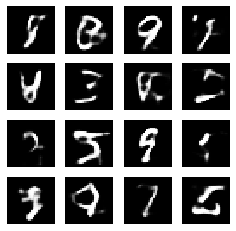

In [13]:
generate_and_save_images(model, 0, random_vector_for_generation)


# running 100 epochs
for epoch in range(1, epochs + 1):
  # counting time
  start_time = time.time()

  # compute grads
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
    # print(train_x, grad)
  end_time = time.time()

  # сounting weighted mean of our Reconst Losses 
  loss = tf.keras.metrics.Mean()

  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  # print(elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, '
        'time elapse for current epoch {}'.format(epoch,
                                                  elbo,
                                                  end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

Now let's inspect our model. 

We will try to encode some number from dataset and then try to decode it.

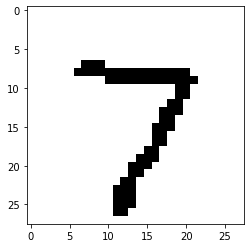

(28, 28, 1)

In [27]:
sample = test_images[0]
show_num(sample)
sample.shape

In [0]:
def reparam_and_decode(model, mean, logvar):
    model.reparameterize(mean, logvar)

(100, 50)


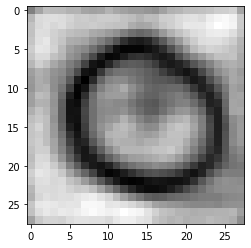

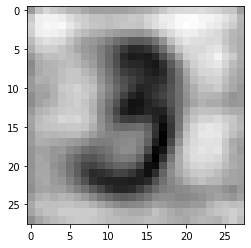

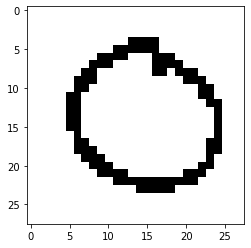

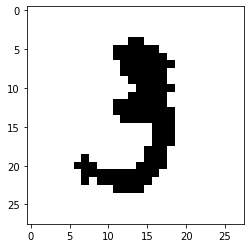

[ 1.0729237  -0.27297455 -1.1089635  -1.1617047  -0.5291097  -1.9056933
 -1.756988   -0.07232621  1.0561675   1.1905509   1.9524217  -0.2083906
  0.0668323  -1.8458488  -0.82168645  0.7955886  -0.30425265 -1.258932
  0.97465575 -0.24790454 -0.04766461 -0.89146936  0.4877107  -2.4468455
 -1.2177006   0.5732259  -0.10381003  0.04092159 -0.80939186  0.6323729
  0.07389399 -2.0906887  -0.70181096 -0.47821075  1.3350972   1.4248744
 -0.64441884  0.8107734  -1.3560908   0.7595379  -0.5913695  -1.078864
  1.682241    2.3412402   1.8519474  -2.5112815   0.27671024 -0.02218395
 -1.0123135   1.144046  ] [-1.193376   -0.22866966  0.2264108  -1.2022094   1.3075453  -0.7875304
  0.20795664 -0.7149406  -0.901653    0.23782776 -1.1632648  -0.02395703
  0.48705694  0.9059143  -1.2254543   0.13320577 -0.20976213 -0.7748824
 -1.9763774  -0.842216    0.50418544 -1.6818014  -0.3955982  -1.4448719
  1.2628107   0.66051316 -1.0359397  -0.47967368  0.8925431   0.09342229
 -0.37738666  1.4156883   1.3673631  

In [195]:
batch = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BATCH_SIZE).batch(BATCH_SIZE)

# iterator = sample_dataset.make_one_shot_iterator()
# el = iterator.get_next()

iterator = tf.compat.v1.data.make_one_shot_iterator(batch)
el = iterator.get_next()
mean, logvar = model.encode(el)
print(mean.shape)
z = model.reparameterize(mean, logvar)
debatch = model.generative_net(z.numpy())
de_im1 = debatch.numpy()[0]
de_im2 = debatch.numpy()[1]
show_num(de_im1)
show_num(de_im2)
im1 = el.numpy()[0]
im2 = el.numpy()[1]
show_num(im1)
show_num(im2)
z1 = z.numpy()[0]
z2 = z.numpy()[1]
print(z1,z2)

How we can see, decoded image is such blured. 

Let's see, how similar im1 and im2 are. To do this, we can initialize $\theta \in [0;1]$ and vary it in function of $\gamma = \theta z_1 + (1 - \theta) z_2,$ which is parameterized function of the segment between $z_1$ and $z_2$ in the space of this vectors.


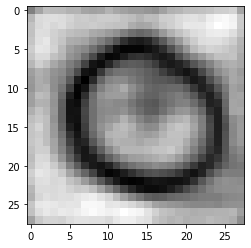

In [196]:
def make_video(arr, i):
    # show_num(arr)
    # time.sleep(0.5)
    img = arr.reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.savefig('capture_of_evol_{}.png'.format(i))
    display.clear_output(wait=False)

thetas = np.linspace(0., 1., num=99)
new_z = [z2]
# new_z = pd.DataFrame(z1)

# i = 1
# for theta in thetas:
#     new_z['{}'.format(i)] = z1*theta + (1-theta)*z2
#     i += 1
# zs = new_z.to_numpy()
for theta in thetas:
    new_z.append(z1*theta + (1-theta)*z2)

# batch_1 = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BATCH_SIZE).batch(BATCH_SIZE)
new_z = np.array(new_z)
new_z.shape

deb = model.generative_net(new_z)
deb_np = deb.numpy()
for i in range(0,100):
    make_video(deb_np[i], i)
    
# debatch = model.generative_net(zs)

In [0]:
import imageio
def make_gif():
    images = []
    filenames = ['capture_of_evol_{}.png'.format(i) for i in range(0,100,4)]
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('movie.gif', images)
make_gif()

# Conclusion.

I've trained simple Neural Network based on Bayes approach, or simply called VAE. 

It shows good results for MNIST on simple CNN net.

We realized the model to do many interesting things from creating similar objects to the original, to checking the similarity between two objects.

In the future, I plan to supplement this work with some improvements, including the study of various divergences instead of KL-divergence. Also, it is interestings to see what happens if two vectors are connected not by a segment but by some curved line when we try to inspect similarity between two vectors.

The training did not last long, but with the reparametrization trick it accelerated several times.



